In [2]:
#Import all necessary packages
import re
import pandas as pd
import nltk
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mlxtend.evaluate import mcnemar
from sklearn import metrics

In [4]:
#The Data_prep() function prepares the data for the experiment. Including, labeling and removing unnecessary data
def Data_prep():
    #Import data
    pd.options.display.max_rows
    pd.set_option('display.max_colwidth', -1)
    traindata = pd.read_csv('[NAMEDATABASE]', sep=',')

    #Create two new columns. The newlabel column will contain one of the five labels. 
        #The firstmessage is default on false, and will be turned to 
        #True when the row contains a message from a customer before the nurse reacts the first time
    traindata['newlabel'] = ' '
    traindata['firstmessage'] = False

    #Replace NaN with a blank value
    traindata['Advies MCC'] = traindata['Advies MCC'].replace(np.nan, '', regex=True)

    #Different checks for the labels, if a row complies to a rule, it will get the according label in the newlabel column
    traindata.loc[traindata['Advies MCC'].str.contains('huisarts') | traindata['Advies MCC'].str.contains('ha') | traindata['Advies MCC'].str.contains('hap'), 'newlabel'] = 'Medical question'
    traindata.loc[traindata['MCC Vangnet Advies'].str.contains('huisarts') | traindata['MCC Vangnet Advies'].str.contains('ha') | traindata['MCC Vangnet Advies'].str.contains('hap'), 'newlabel'] = 'Medical question'
    traindata.loc[traindata['label'] == 'Informatievraag', 'newlabel'] = 'Medical question'
    traindata.loc[traindata['NHG urgentie score'].notnull() | traindata['Arts urgentie score'].notnull(), 'newlabel'] = 'Medical question'
    traindata.loc[traindata['label'] == 'Klantenservice', 'newlabel'] = 'Helpdesk'
    traindata.loc[traindata['Advies MCC'].str.contains('ks') | traindata['Advies MCC'].str.contains('klantenservice') , 'newlabel'] = 'Helpdesk'
    traindata.loc[traindata['Inzet 2e lijn'].notnull() & traindata['NHG urgentie score'].isnull() & traindata['Arts urgentie score'].isnull(), 'newlabel'] = 'Medical question'

    #Default setting nursesendmessage to False. This will be used in the following loop.
    nursesendmessage = False
    conversationid = 10000

    #For every row in traindata, do the following
    for index, row in traindata.iterrows(): 

        #Restart the loop. When the current conversation id is not the same as the previous one, it will save the new one
        # and will set the nursesendmessage parameter back to False
        if conversationid != row['conversation_id']:
            conversationid = row['conversation_id']
            nursesendmessage = False

        #If the customer send the message and the nurse did not respond yet, set the value of the firstmessage column to True
        if row['AfzenderIsKlant'] == 1 and nursesendmessage == False:
            traindata.set_value(index,'firstmessage', True)

        #Otherwise, the first time when the nurse responds, set the nursesendmessage parameter to True. 
        #So new messages by customers are not taken into account. It will reset when a new conversation id is found.
        elif row['AfzenderIsKlant'] == 0:
            nursesendmessage = True

    #Create new dataset which only contains the first messages
    firstmessagesdata = traindata.loc[traindata['firstmessage'] == True]

    #Exclude all conversations that are not Dutch
    firstmessagesdata = firstmessagesdata.loc[firstmessagesdata['conversation_language'] == 'nl']
    
    #Create new dataset
    dataset = firstmessagesdata[['conversation_id', 'Tekst', 'newlabel']].copy()

    #Exclude everything that contains a NaN value in the Tekst column
    dataset = dataset[dataset['Tekst'].notnull()]

    #Exclude everything that was not labeled before (54 cases)
    dataset = dataset[dataset['newlabel'] != ' ']

    #Combine all Texts with the same conversation id and add a space between sentences
    dataset = dataset.groupby(['conversation_id', 'newlabel'])['Tekst'].apply(lambda x: ' '.join(x)).reset_index()

    #Exclude the conversation id column from the dataset
    dataset = dataset[['Tekst', 'newlabel']].copy()

    dataset['category_id'] = dataset['newlabel'].factorize()[0]
    
    #Return the dataset as output of this function
    return dataset

#The Train_test_split() function splits the dataset into a train set and test set (standard 70% train set).
# It is also possible to use a balancemethod (Oversample and Undersample), Default is None.
def Train_test_split(dataset, balancemethod):
    #The % of trainsize. For this experiment it is fixed at 70% trainset
    trainsize = .70

    #Split the dataset into two datasets, one containing the helpdesk questions and one the medical questions
    df_medisch = dataset[dataset.newlabel=='Medical question']
    df_helpdesk = dataset[dataset.newlabel=='Helpdesk']

    #Split the helpdesk dataset into train and testset
    i = int(len(df_helpdesk) * trainsize)
    df_helpdesk_train = df_helpdesk[:i]
    df_helpdesk_test = df_helpdesk[i:]

    #Split the medical questions dataset into train and testset
    i = int(len(df_medisch) * trainsize)
    df_medisch_train = df_medisch[:i]
    df_medisch_test = df_medisch[i:]

    #If the selected balance method is oversample, do:
    if(balancemethod == 'Oversample'):
        # Oversample minority class
        df_helpdesk_train = resample(df_helpdesk_train, 
                                         replace=True,     # sample with replacement
                                         n_samples=int(len(df_medisch) * trainsize),    # to match majority class
                                         random_state=123) # reproducible results
        
    #If the selected balance method is undersample, do:
    elif(balancemethod == 'Undersample'):
        # Undersample majority class
        df_medisch_train = resample(df_medisch_train, 
                                         replace=True,     # sample with replacement
                                         n_samples=int(len(df_helpdesk) * trainsize),    # to match minority class
                                         random_state=123) # reproducible results
        
    #If the selected balance method is None, do:
    elif(balancemethod == 'None'):
        #Do nothing
        pass

    #Combine majority class with upsampled minority class
    df_train = pd.concat([df_medisch_train, df_helpdesk_train])
    df_test = pd.concat([df_medisch_test, df_helpdesk_test])

    #Return the train- and test set as output for this function
    return df_train, df_test

#The vectorize function vectorizes the train- and test set using TF-IDF and n-grams. The amount of n-grams can be
# determined in the function
def vectorize(datatrain, datatest, ngram):
    #Create tfidf set with a certain n-gram range
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',encoding='latin-1', ngram_range=(1, ngram))

    #Create the labels for both the train- and test set
    labels_train = datatrain.newlabel
    labels_test = datatest.newlabel

    #Create the features for both the train- and test set
    features_train = tfidf.fit_transform(datatrain.Tekst).toarray()
    features_test = tfidf.transform(datatest.Tekst).toarray()
    
    #Return the labels and features of both the train- and test set as output of this function
    return labels_train, labels_test, features_train, features_test

#The prep_model function uses the previous made train- and test set, labels, and features
# it is possible to select a model that you want to use on the train- and test set. In addition, it is possible to
# print the results of this model in both a confusion matrix as a table containing the precision, recall and F-score
def prep_model(df_train, df_test, labels_train, labels_test, features_train, features_test, model, printresults):
    
    #First, select the chosen model (text classifier)
    if(model == 'KNN'):
        model = KNeighborsClassifier()
        
    elif(model == 'NB'):
        model = MultinomialNB()
        
    elif(model == 'RF'):
        model = RandomForestClassifier(n_estimators=200, max_depth=3,random_state=0)
        
    elif(model == 'SVM'):
        model = LinearSVC()

    #Create the X and y values of the train and test set
    none3, X_test, none4, y_test, ind2ices_train, indices_test = train_test_split(features_test, labels_test, df_test.index, test_size=0.99, random_state=1)
    X_train, none1, y_train, none2, indices_train, indices_test = train_test_split(features_train, labels_train, df_train.index, test_size=0.00, random_state=0)

    #Run the model
    model.fit(X_train, y_train)
    
    #Save the prection of the model on the test set
    y_pred = model.predict(X_test)
    
    #If printresults is True, execute the Print_results function
    if(printresults == True):
        Print_results(y_test, y_pred)
       
    #Return the y_test (actual labels of test set) and the y_pred (predicetd labels of test set by model)
    return y_test, y_pred

#The Print_results function uses the y_test and y_pred of the prep_model function to make a confusion matrix
# and performance tabel
def Print_results(y_test, y_pred):
    #Create the confusion matrix and print it with the right labels
    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Helpdesk', 'Medical question'], yticklabels=['Helpdesk', 'Medical question'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    #Print the performance tabel including precision, recall and F-score
    print(metrics.classification_report(y_test, y_pred, target_names = ['Helpdesk', 'Medical question']))

#The McNemar fuction uses the real labels and two predicted labels by two different prep_model functions
# in this way, it is possible to find the differences between two confusion matrixes
def McNemar(realtest, pred1, pred2):
    #Create columns
    d = {'Real': realtest, 'pred1': pred1, 'pred2' : pred2, 'a': 0, 'b': 0, 'c': 0, 'd': 0}

    #Create new dataset
    comparingdataset = pd.DataFrame(data=d)

    #Fill in the columns a - d. 'a' means that both predictors found the right label
    # 'b' means that only the first predictor found the right label
    # 'c' means that only the second predictor found the right label
    # 'd' means that both predictors did not found the right label
    comparingdataset.loc[(comparingdataset['Real'] == comparingdataset['pred1']) & (comparingdataset['Real'] == comparingdataset['pred2']), 'a'] = 1
    comparingdataset.loc[(comparingdataset['Real'] == comparingdataset['pred1']) & (comparingdataset['Real'] != comparingdataset['pred2']), 'b'] = 1
    comparingdataset.loc[(comparingdataset['Real'] != comparingdataset['pred1']) & (comparingdataset['Real'] == comparingdataset['pred2']), 'c'] = 1
    comparingdataset.loc[(comparingdataset['Real'] != comparingdataset['pred1']) & (comparingdataset['Real'] != comparingdataset['pred2']), 'd'] = 1

    #Calculate the amount of rows belonging to every group 
    a = comparingdataset['a'].sum()
    b = comparingdataset['b'].sum()
    c = comparingdataset['c'].sum()
    d = comparingdataset['d'].sum()
    
    #Place the numbers in an table array
    x = np.array([[a, b],
              [c, d]])
    
    #If b+c is higher than 25, use the corrected method
    if(b+c > 25):
        chi2, p = mcnemar(ary=x, corrected=True) #corrected when b+c > 25. Otherwise 'exact'
       
    #Otherwise, use the exact method
    else:
        chi2, p = mcnemar(ary=x, exact=True) #exact when b+c <= 25. Otherwise 'corrected'
        
    #Print the numbers of b and c, the chi2 value, and the significance p value
    print(b,c)
    print('chi2:', chi2)
    print('p:', p)
    
#The Calc_Performance function simply calculates the performance of a model in precision, recall, and F-score by
# using multiple functions described above
def Calc_Performance(data, balancingmethod, ngrams, model):
    trainset, testset = Train_test_split(data, balancingmethod)
    labels_train, labels_test, features_train, features_test = vectorize(trainset, testset, ngrams)
    prep_model(trainset, testset, labels_train, labels_test, features_train, features_test, model, True)
    
#The Sig_between_classifiers function calculates the McNemar test for two different predicters which 
# have different models
def Sig_between_classifiers(data, balancingmethod, ngrams, model1, model2):
    trainset, testset = Train_test_split(data, balancingmethod)
    labels_train, labels_test, features_train, features_test = vectorize(trainset, testset, ngrams)
    realtest, pred1 = prep_model(trainset, testset, labels_train, labels_test, features_train, features_test, model1, False)
    realtest, pred2 = prep_model(trainset, testset, labels_train, labels_test, features_train, features_test, model2, False)
    McNemar(realtest, pred1, pred2)
    
#The Sig_between_balancing function calculates the McNemar test for two different predicters which 
# have different balancing methods
def Sig_between_balancing(data, balancingmethod1, balancingmethod2, ngrams, model):
    trainset1, testset1 = Train_test_split(data, balancingmethod1)
    trainset2, testset2 = Train_test_split(data, balancingmethod2)
    labels_train1, labels_test1, features_train1, features_test1 = vectorize(trainset1, testset1, ngrams)
    labels_train2, labels_test2, features_train2, features_test2 = vectorize(trainset2, testset2, ngrams)
    realtest, pred1 = prep_model(trainset1, testset1, labels_train1, labels_test1, features_train1, features_test1, model, False)
    realtest, pred2 = prep_model(trainset2, testset2, labels_train2, labels_test2, features_train2, features_test2, model, False)
    McNemar(realtest, pred1, pred2)

#The Sig_between_ngrams function calculates the McNemar test for two different predicters which 
# have different numbers of n-grams
def Sig_between_ngrams(data, balancingmethod, ngrams1, ngrams2, model):
    trainset, testset = Train_test_split(data, balancingmethod)
    labels_train1, labels_test1, features_train1, features_test1 = vectorize(trainset, testset, ngrams1)
    labels_train2, labels_test2, features_train2, features_test2 = vectorize(trainset, testset, ngrams2)
    realtest, pred1 = prep_model(trainset, testset, labels_train1, labels_test1, features_train1, features_test1, model, False)
    realtest, pred2 = prep_model(trainset, testset, labels_train2, labels_test2, features_train2, features_test2, model, False)
    McNemar(realtest, pred1, pred2)

In [5]:
#Prepare the data one time
data = Data_prep()

/home/612874/.local/share/virtualenvs/612874-_SwZZs5k/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


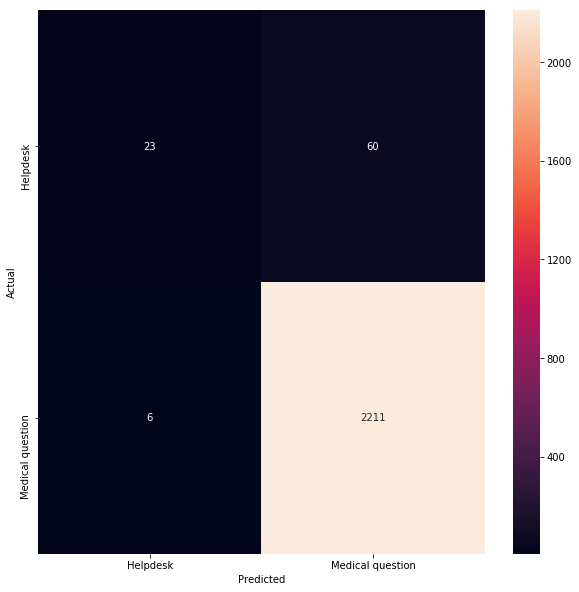

                  precision    recall  f1-score   support

        Helpdesk       0.79      0.28      0.41        83
Medical question       0.97      1.00      0.99      2217

     avg / total       0.97      0.97      0.96      2300



In [6]:
#Calc_Performance(data, balancingmethod, ngrams, model)
#options for balance: Oversample, Undersample or None (default), ngrams 1-4, model: SVM, KNN, NB, RF
Calc_Performance(data, 'Oversample', 3, 'SVM')

In [7]:
#Sig_between_classifiers(data, balancingmethod, ngrams, model1, model2)
#options for balance: Oversample, Undersample or None (default), ngrams 1-4, model: SVM, KNN, NB, RF
Sig_between_classifiers(data, 'Oversample', 1, 'SVM', 'NB')

55 22
chi2: 13.2987012987013
p: 0.00026559001939264044


In [8]:
#Sig_between_balancing(data, balancingmethod1, balancingmethod2, ngrams, model)
#options for balance: Oversample, Undersample or None (default), ngrams 1-4, model: SVM, KNN, NB, RF
Sig_between_balancing(data, 'None', 'Oversample', 3, 'NB')

14 31
chi2: 5.688888888888889
p: 0.017072661093788417


In [9]:
#Sig_between_ngrams(data, balancingmethod, ngrams1, ngrams2, model)
#options for balance: Oversample, Undersample or None (default), ngrams 1-4, model: SVM, KNN, NB, RF
Sig_between_ngrams(data, 'Oversample', 1, 3, 'SVM')

15 16
chi2: 0.0
p: 1.0
